In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import itertools
from math import comb
from sklearn.preprocessing import LabelEncoder
sns.set_style("darkgrid")
sns.set_context("notebook")
warnings.filterwarnings('ignore')

In [6]:
league_id = 145
opening_day = '2046-03-29'
season_end = '2046-09-30'
dir = 'C:\\Users\\night\\Documents\\Out of the Park Developments\\OOTP Baseball 23\\saved_games\\SBC.lg\\import_export\\csv\\'


In [7]:
teams_columns = ['team_id', 'name','nickname','abbr','city_id','park_id','sub_league_id','division_id']

teams = pd.read_csv(dir+'teams.csv')
teams = teams.loc[(teams['league_id'] == league_id) & (teams['team_id'] < 85),teams_columns]

In [8]:
# Creating a Dataframe of all games in the regular season
game_prep = pd.read_csv(dir+'games.csv')

# Converting the date column to datetime
game_prep['date'] = game_prep['date'].astype('datetime64[ns]')

game_prep = game_prep[(game_prep['date'] >= opening_day ) &
                      (game_prep['date'] < season_end) &
                      (game_prep['league_id'] == league_id) &
                      (game_prep['game_type'] == 0)] 


In [9]:
# Creating Dataframe with Player names, IDs, 
allplayers_cols = ['first_name','last_name','player_id', 'team_id', 'league_id','position','role']

allplayers = pd.read_csv(dir+'players.csv')
allplayers = allplayers.loc[allplayers['league_id'] == league_id, allplayers_cols]

In [10]:
allplayers

,first_name,last_name,player_id,team_id,league_id,position,role
39,Yannick,van der Heiden,46,39,145,2,0
125,Esteban,Melgosa,160,59,145,5,0
133,Esteban,Colindres,169,48,145,4,0
138,Jim,Broussard,174,47,145,5,0
172,Zach,Marcinik,228,33,145,8,0
...,...,...,...,...,...,...,...
49976,Vitantonio,Girometta,51407,58,145,6,0
50023,Juan,Brambila,51454,34,145,5,0
50040,Jorge,Medina,51471,38,145,1,13
50084,Luis,Arroyo,51515,33,145,5,0


In [11]:
# Create a Baseline Pitcher Dataframe
sp = pd.read_csv(dir+'players_game_pitching_stats.csv')


# Include Role to only include SP
sp = sp.merge(allplayers[['player_id','role']], on='player_id', how='left')

#df = pd.merge(df,df2[['Key_Column','Target_Column']],on='Key_Column', how='left')

# Limit the game id's to reflect regular season only
sp = sp[(sp['game_id'] >= 26) & (sp['game_id'] < 2000) & (sp['role'] == 11)]

# To Replacing all na's with 0. Most pitching statistics at the raw level are incremental counters.
sp = sp.replace([np.inf, -np.inf], np.nan).fillna(0).drop('role', axis = 1)

# Limit the data to only focus on the NBC level, and team ID's that do not include all star teams.
sp = sp[(sp['league_id'] == league_id) & (sp['team_id'] <= 85)]

# IP adjustments to properly compute innings pitched.
sp['ip'] = round(sp['outs'] / 3,2)

# Constructing 
sp["ip_over_4"] = np.where(sp['outs'] > 12, np.floor(sp['ip']-4),0).astype('int')

# Calculation of Game Score columns
sp_cols = ['team_id', 'player_id','game_id','outs','ip', 'ip_over_4','ha','k', \
            'bb', 'qs', 'hra', 'gb', 'fb', 'wpa', 'er', 'r']
sp = sp[sp_cols]


In [12]:
sp

,team_id,player_id,game_id,outs,ip,ip_over_4,ha,k,bb,qs,hra,gb,fb,wpa,er,r
271,60,300,634,5,1.67,0,3,1,1,0,0,1,3,-0.1414,0,0
272,60,300,668,3,1.00,0,1,2,0,0,0,1,0,0.0380,0,0
273,60,300,732,6,2.00,0,1,1,0,0,0,2,3,0.2754,0,0
274,60,300,751,3,1.00,0,2,0,1,0,0,0,2,0.1203,0,0
275,60,300,799,5,1.67,0,1,2,1,0,0,1,2,0.3084,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84059,41,51391,1424,11,3.67,0,2,7,2,0,0,0,4,0.1383,0,0
84060,41,51391,1517,12,4.00,0,3,4,1,0,0,3,5,-0.0826,2,2
84061,41,51391,1601,18,6.00,2,1,4,2,1,1,8,6,0.2868,1,1
84062,41,51391,1668,8,2.67,0,2,4,3,0,0,2,2,-0.1715,3,3


In [13]:
# Copy the Baseline Pitcher Dataframe for both team and player level calculations
# This needs to be achieved prior to computations to allow for flexibility.
player_level = sp.copy()

player_level = player_level[['team_id', 'player_id','game_id','outs','ip_over_4','k','ha','hra','er','r','bb']]

player_level = player_level.groupby(['team_id', 'player_id','game_id']).agg('sum')

player_level = player_level[player_level['outs'] > 9]

player_level['james_ts'] = (50 + \
                           (1*player_level['outs']) + \
                           (2*player_level['ip_over_4']) + \
                           (1*player_level['k']) - \
                           (2*player_level['ha']) - \
                           (4*player_level['er']) - \
                           (2*(player_level['r']-player_level['er'])) - \
                           (1*player_level['bb']))

player_level['tango_ts'] = (40 + \
                           (2*player_level['outs']) + \
                           (1*player_level['k']) - \
                           (2*player_level['bb']) - \
                           (2*player_level['ha']) - \
                           (3*player_level['r']) - \
                           (6*player_level['hra']))

james_mean = player_level['james_ts'].mean() 
james_std = player_level['james_ts'].std() 
tango_mean = player_level['tango_ts'].mean() 
tango_std = player_level['tango_ts'].std() 

# Ungroup the Dataframe
player_level = player_level.reset_index()

team_means = player_level[['team_id', 'james_ts','tango_ts']].groupby(['team_id']).agg('mean').astype(int)
team_means

,james_ts,tango_ts
team_id,,
31,52,54
32,58,59
33,45,44
34,52,52
35,48,49
36,57,59
37,51,51
38,53,54
39,53,54


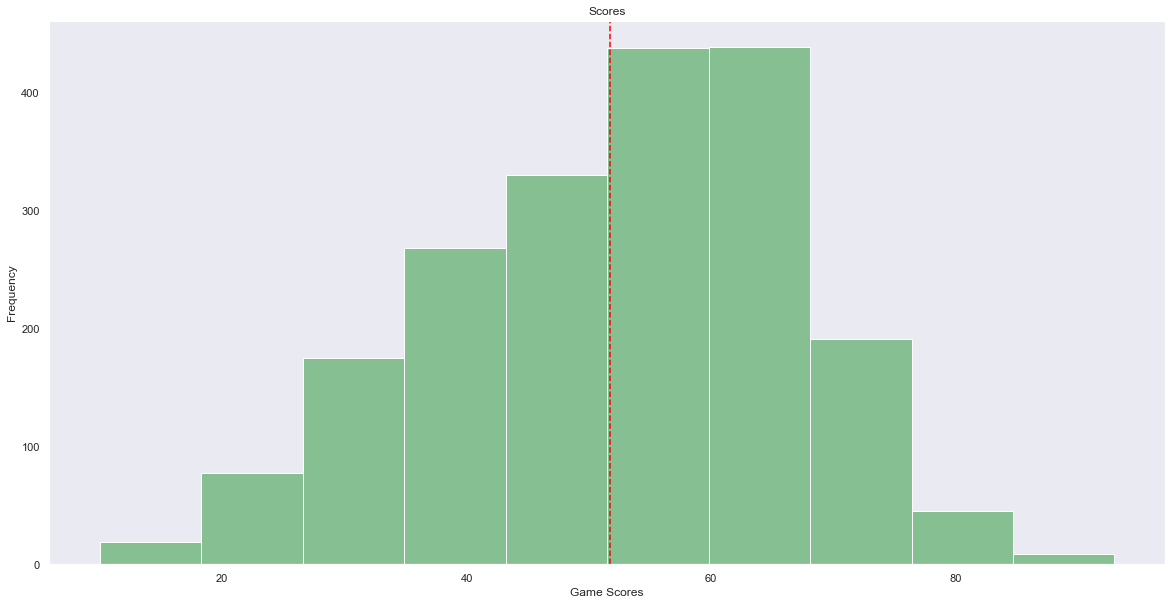

In [14]:
mean=team_means['james_ts'].mean()
median=team_means['james_ts'].median()

team_means_histj = player_level.hist(column = 'james_ts',grid=False, figsize=(20,10), color='#86bf91')
for ax in team_means_histj.flatten():
    ax.set_xlabel("Game Scores")
    ax.set_ylabel("Frequency")
    ax.set_title("Scores")
    ax.axvline(mean, color='r', linestyle='--')

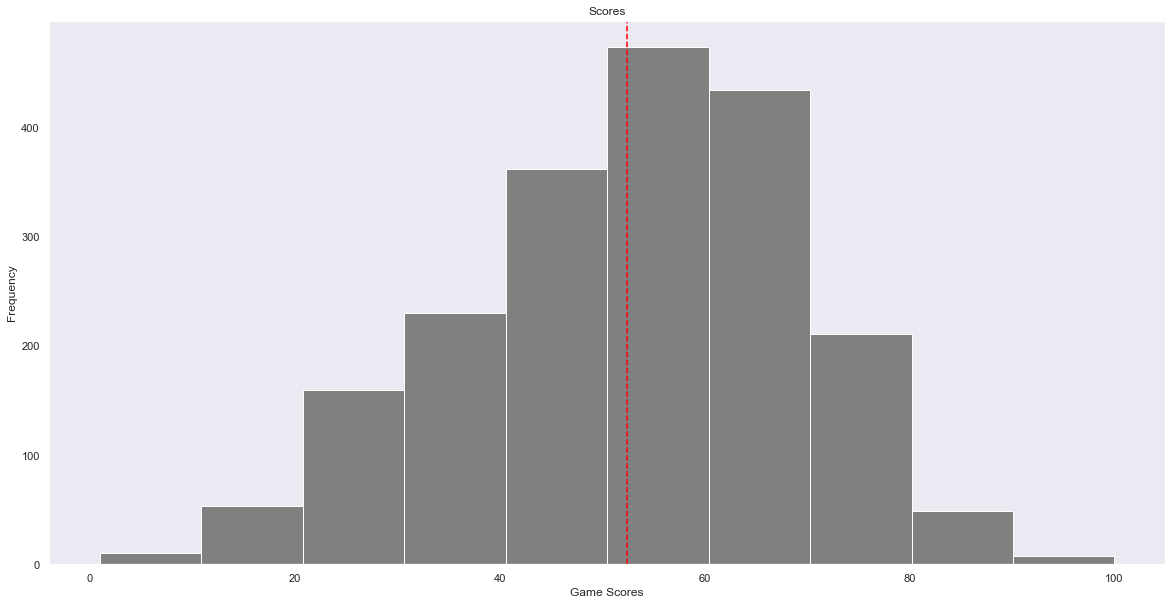

In [15]:
meant=team_means['tango_ts'].mean()
mediant=team_means['tango_ts'].median()

team_means_histt = player_level.hist(column = 'tango_ts',grid=False, figsize=(20,10), color='grey')
for ax in team_means_histt.flatten():
    ax.set_xlabel("Game Scores")
    ax.set_ylabel("Frequency")
    ax.set_title("Scores")
    ax.axvline(meant, color='r', linestyle='--')

In [16]:
sp['james_gs'] = (50 + \
                (1*sp['outs']) + \
                (2*sp['ip_over_4']) + \
                (1*sp['k']) - \
                (2*sp['ha']) - \
                (4*sp['er']) - \
                (2*(sp['r']-sp['er'])) - \
                (1*sp['bb']))

sp['tango_gs'] = (40 + \
                (2*sp['outs']) + \
                (1*sp['k']) - \
                (2*sp['bb']) - \
                (2*sp['ha']) - \
                (3*sp['r']) - \
                (6*sp['hra']))


#sp[sp==np.inf]=np.nan
#sp.fillna(0, inplace=True)
std_james = sp['james_gs'].std()
std_tango = sp['tango_gs'].std()
sp = sp.merge(team_means, how = 'left', on = 'team_id')
sp
raw_cols = ['team_id', 'player_id','game_id', 'outs','ip', 'ip_over_4','ha','k', \
            'bb', 'qs', 'hra', 'gb', 'fb', 'wpa', 'er', 'r','james_gs','tango_gs', \
            'james_ts','tango_ts']

pitchers_raw = sp[raw_cols]

array([[<AxesSubplot:title={'center':'james_gs'}>]], dtype=object)

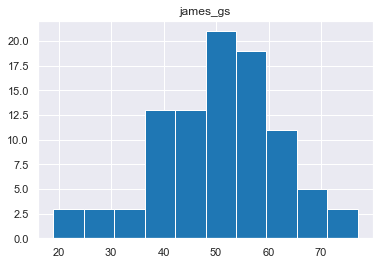

In [17]:
pitchers = pitchers_raw.merge(allplayers, how = 'left', on=('player_id'))
#players = players[(players['game_id'] >= 26) & (players['game_id'] < 2000)]
players_columns = ['first_name', 'last_name', 'player_id','team_id_x', 'game_id','position', \
                   'role','outs','ip', 'k', 'bb', 'qs', 'hra', 'ha', 'gb', 'fb', 'wpa', 'er', 'r', \
                   'james_gs','james_ts','tango_gs','tango_ts']

pitchers = pitchers[players_columns]
pitchers = pitchers[(pitchers['position'] == 1) | (pitchers['position'] == 9)]
pitchers['start'] = 1

starters = pitchers[(pitchers['role'] == 0 )| (pitchers['role'] == 11)]
relievers = pitchers[(pitchers['role'] == 12 )| (pitchers['role'] == 13)]


pitchers[pitchers['team_id_x']== 47].hist('james_gs')

In [18]:
def team_eval(df, model, team_id=0):
    data = df.copy()
    if team_id != 0:
        data = df[df['team_id_x'] == team_id]
    data = data.groupby(['first_name', 'last_name','player_id','team_id_x','position','role']).agg('sum') \
            .reset_index().drop(['position','role','game_id','player_id'],axis = 1).set_index('team_id_x')
    data['WHIP'] = round((data['ha'] + data['bb']) / data['ip'],2).fillna(0)
    data['K/BB'] = round((data['k']/data['bb']),2).fillna(0)
    data['Quality'] = data['qs'].fillna(0)
    data['K/9']  = round(((data['k']/data['ip'])*9),2).fillna(0)
    data['HR/9'] = round(((data['hra']/data['ip'])*9),2).fillna(0)
    data['BB/9'] = round(((data['bb']/data['ip'])*9),2).fillna(0)
    data['GB%'] = round(((data['gb'])/(data['fb']+data['gb']))*100,1).fillna(0)
    data['ERA'] = round(((data['er']/data['ip'])*9),2).fillna(0)
    data['Starts'] = data['start']
    data['QS%'] = round((data['qs'] / data['start'])*100,1)
    data['ip'] = round(data['ip'],1)
    if model == 'tango':
        data['GS'] = round(data['tango_gs']/data['start'],0).astype(int)
        data['Norm GS'] = round((data['GS'] - tango_mean) / tango_std,1)
    else:
        data['GS'] = round(data['james_gs']/data['start'],0).astype(int)
        data['Norm GS'] = round((data['GS'] - james_mean) / james_std,1)    
    data['Name'] = data['first_name'] + " " + data['last_name']
    data.columns = data.columns.str.lower()
    return data[['name','starts','qs%','ip','gs','norm gs','era','k/9',
                'bb/9','hr/9','k/bb','gb%','whip']].sort_values('qs%',ascending = False)

In [19]:
game_prep = game_prep[(game_prep['league_id'] == league_id) & (game_prep['innings'] > 0) & (game_prep['game_type'] == 0)]
game_prep['winner'] = np.where(game_prep['runs0'] < game_prep['runs1'], game_prep['home_team'], game_prep['away_team'])
game_prep['loser'] = np.where(game_prep['runs0'] > game_prep['runs1'], game_prep['home_team'], game_prep['away_team'])
game_cols = ['game_id','date', 'home_team', 'away_team', 'winner', 'loser']
games = game_prep[game_cols].reset_index(drop = True)
games['date'] = games['date'].astype('datetime64').dt.normalize()
start_date = min(games['date'])
games['Season'] = pd.DatetimeIndex(games['date']).year
games['Daynum'] = ((games['date'] - start_date)/ np.timedelta64(1,'D') + 1).astype('int')
#games = pd.concat([games,game_prep_dates], keys = 'date', ignore_index = True)
games['Win_OOTP'] = games['winner']
games['Lose_OOTP'] = games['loser']

In [20]:
le = LabelEncoder()
games.winner = le.fit_transform(games.winner)
games.loser = le.fit_transform(games.loser)

In [21]:
teams_revised = pd.DataFrame({'mapped': games['winner'], 'original':games['Win_OOTP']}).sort_values('mapped')
teams_revised = teams_revised.drop_duplicates().reset_index(drop=True)
teams_revised['elo start']  = 1500
teams_revised

,mapped,original,elo start
0,0,31,1500
1,1,32,1500
2,2,33,1500
3,3,34,1500
4,4,35,1500
5,5,36,1500
6,6,37,1500
7,7,38,1500
8,8,39,1500
9,9,40,1500


ELO Process. 

1. For each win, add your opponent's rating + 400
2. For each loss, add your opponent's rating minus 400
3. Divide the sum by the number of played games. 

Team Wins = Team's ELO Day of Game + Opponent's ELO Day of game + 400 then divide by Team GP 
Team Loss = Team's ELO Day of Game + Opponent's ELO Day of game - 400 then divide by Team GP

In [29]:
games['welo'] = 0
games['nwelo'] = 0
games['lelo'] = 0
games['nlelo'] = 0

elo_per_season = {}
n_teams = len(teams.team_id.unique())
current_elos = np.array(np.ones(shape=(n_teams)) * teams_revised['elo start'])

0       2046
1       2046
2       2046
3       2046
4       2046
        ... 
1161    2046
1162    2046
1163    2046
1164    2046
1165    2046
Name: Season, Length: 1166, dtype: int64

In [23]:
games['total_days'] = games.Daynum
df_team_elos = pd.DataFrame(index=games.total_days.unique(), 
                            columns=range(n_teams))
df_team_elos.iloc[0, :] = current_elos

In [24]:
def update_elo(winner_elo, loser_elo):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected_result(winner_elo, loser_elo)
    change_in_elo = k_factor * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

def expected_result(elo_a, elo_b):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
    return expect_a

def update_end_of_season(elos):
    """Regression towards the mean
    
    Following 538 nfl methods
    https://fivethirtyeight.com/datalab/nfl-elo-ratings-are-back/
    """
    diff_from_mean = elos - mean_elo
    elos -= diff_from_mean/3
    return elos

In [25]:
mean_elo = 1500
elo_width = 400
k_factor = 18.5

for row in games.itertuples():
    idx = row.Index
    w_id = row.winner
    l_id = row.loser

    # Get current elos
    welo = current_elos[w_id]
    lelo = current_elos[l_id]

    # Update on game results
    nwelo, nlelo = update_elo(welo, lelo)

    # Save updated elos
    games.at[idx, 'welo'] = welo
    games.at[idx, 'lelo'] = lelo
    games.at[idx, 'nwelo'] = nwelo
    games.at[idx, 'nlelo'] = nlelo
    current_elos[w_id] = nwelo
    current_elos[l_id] = nlelo

    # Save elos to team DataFrame
    today = row.total_days
    df_team_elos.at[today, w_id] = nwelo
    df_team_elos.at[today, l_id] = nlelo

In [30]:
n_samples = len(games)
samples = games[games.Season == 2046].sample(n_samples)
loss=0
expected_list = []
for row in samples.itertuples():
    w_elo = row.welo
    l_elo = row.lelo
    w_expected = expected_result(w_elo, l_elo)
    expected_list.append(w_expected)
    loss += np.log(w_expected)
print(loss/n_samples)

-0.6931471805599262


Text(0, 0.5, 'Counts')

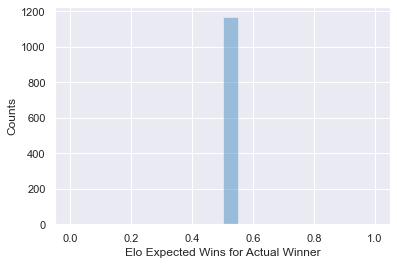

In [31]:
sns.distplot(expected_list, kde=False, bins=20)
plt.xlabel('Elo Expected Wins for Actual Winner')
plt.ylabel('Counts')

In [32]:
max_index = max(df_team_elos.index)
current_elo = pd.DataFrame(df_team_elos.iloc[-1,:])
teams_revised['current_elo'] = current_elo[max_index]
teams_revised['current_elo'] = teams_revised['current_elo'].astype('float').round(1)
teams_curr = teams.join(teams_revised, lsuffix = 'team_id', rsuffix = 'original').drop(['mapped','original','current_elo'],axis = 1)
teams_curr['elo start'] = round(teams_curr['elo start'],0).astype(int)

In [33]:
eval_cols = ['game_id', 'date', 'home_team', 'away_team', 'Win_OOTP', 'Lose_OOTP', 'welo', 'nwelo', 'lelo', 'nlelo']
games_final = games[eval_cols].set_index('game_id')
games_final = games_final.rename(columns = {'Win_OOTP':'winner', 'Lose_OOTP':'loser', 'welo':'winner elo before', 'nwelo': 'winner elo after', 'lelo': 'loser elo before', 'nlelo': 'loser elo after'})

elo_columns = ['winner','winner elo after','loser','loser elo after']
recent_games = games_final[games_final['date'] == max(games_final['date'])]
recent_games = recent_games[elo_columns]

winner = pd.DataFrame()
loser = pd.DataFrame()
winner['team'] = recent_games['winner']
winner['elo'] = recent_games['winner elo after']
loser['team'] = recent_games['loser']
loser['elo'] = recent_games['loser elo after']

curr_elo = pd.concat([winner,loser]).reset_index().drop('game_id',axis=1).sort_values('team')
final_elo = teams_curr.merge(curr_elo, how='left', left_on='team_id', right_on = 'team') \
            .set_index('team_id').drop('team',axis=1).rename(columns={'elo':'current elo'})
final_elo['change'] = final_elo['current elo'] - final_elo['elo start']

In [34]:
final_elo.sort_values('change', ascending = False)

,name,nickname,abbr,city_id,park_id,sub_league_id,division_id,elo start,current elo,change
team_id,,,,,,,,,,
31,Carolina,Swamp Foxes,CAR,18952,13,1,1,1500,0,-1500
32,Atlanta,Braves,ATL,4704,528,1,0,1500,0,-1500
59,Toronto,Blue Jays,TOR,80680,41,0,0,1500,0,-1500
58,Texas,Rangers,TEX,4076,40,0,2,1500,0,-1500
57,Montreal,Expos,MTL,51650,39,0,0,1500,0,-1500
56,St. Louis,Cardinals,STL,69095,38,1,1,1500,0,-1500
55,San Francisco,Giants,SF,69999,37,1,2,1500,0,-1500
54,Seattle,Mariners,SEA,72460,36,0,2,1500,0,-1500
53,Golden State,Grizzlies,GS,0,35,0,2,1500,0,-1500


In [35]:
def playoff_match(team1, team2, model=''):
    team_1 = team_eval(pitchers,model,team1).reset_index()
    team_2 = team_eval(pitchers,model,team2).reset_index()
    team_1_elo = final_elo.loc[final_elo.index == team1,'current elo'].values[0]
    team_2_elo = final_elo.loc[final_elo.index == team2,'current elo'].values[0]
    team_1['elo'] = team_1_elo
    team_2['elo'] = team_2_elo
    if model == 'james':
        team_1['team_score'] = team_means.loc[team1,'james_ts']
        team_2['team_score'] = team_means.loc[team2,'james_ts']
    else:
        team_1['team_score'] = team_means.loc[team1,'tango_ts']
        team_2['team_score'] = team_means.loc[team1,'tango_ts']
    teams_df = team_1.merge(team_2,'outer')
    teams_df['sp_effect'] = 4.7 * (teams_df['gs'] - teams_df['team_score'])
    teams_df['rev_elo'] = teams_df['elo'] + teams_df['sp_effect']
    return teams_df


In [36]:
rcr_anc = playoff_match(47,45,'james')
okc_nsh = playoff_match(58,56,'james')

with pd.ExcelWriter('vbc_2023_postseason.xlsx') as writer:
    rcr_anc.to_excel(writer,sheet_name ='rcr_anc')
    boz_har.to_excel(writer,sheet_name ='boz_har')
    anc_ind.to_excel(writer,sheet_name ='anc_ind')
    mad_hon.to_excel(writer,sheet_name ='mad_hon')
    boz_nsh.to_excel(writer,sheet_name ='boz_nsh')
    cha_moj.to_excel(writer,sheet_name ='cha_moj')
    anc_hon.to_excel(writer,sheet_name ='anc_hon')
    nsh_moj.to_excel(writer,sheet_name ='nsh_moj')
    okc_nsh.to_excel(writer,sheet_name ='hon_nsh')

ModuleNotFoundError: No module named 'openpyxl'

In [37]:
hon_nsh

NameError: name 'hon_nsh' is not defined

In [38]:
okc = team_eval(pitchers,'james',58)
#mexico.rename(columns = {'starts':'appearances'})
okc

,name,starts,qs%,ip,gs,norm gs,era,k/9,bb/9,hr/9,k/bb,gb%,whip
team_id_x,,,,,,,,,,,,,
58,Everton Brakes,14,57.1,74.7,55,0.2,3.13,7.11,3.50,1.33,2.03,45.9,1.19
58,Nazario Farelo,22,27.3,81.0,51,-0.1,4.11,5.89,2.56,1.00,2.30,49.2,1.15
58,Chris Blake,15,26.7,72.7,48,-0.3,4.09,5.70,3.59,1.11,1.59,50.0,1.40
58,Luis Barrientos,14,14.3,48.0,53,0.0,3.00,7.31,4.69,0.56,1.56,42.6,1.19
58,Juan Flores,14,7.1,41.7,47,-0.4,4.97,7.13,3.67,1.30,1.94,44.2,1.58
58,Murdock Gilcrist,23,4.3,53.3,48,-0.3,5.06,7.59,2.87,1.18,2.65,39.4,1.46


In [ ]:
four = comb(3,3)
five = comb(4,3)
six = comb(5,3)
seven = comb(6,3)
eight = comb(7,3)
nine = comb(8,3)

In [ ]:
four + five + six + seven

In [ ]:

# for row in players.itertuples():
#     inn = math.modf(players.at[row.Index, 'ip'])[1]
#     frac = math.modf(players.at[row.Index, 'ip'])[0]
#     if round(frac,1) == 0.1:
#         players.at[row.Index,'ip'] = (inn + .3333)
#     if round(frac,1) == 0.2:
#         players.at[row.Index,'ip'] = (inn + .6667)

# test = players[(players['team_id_x']==38) & (players['last_name'] == 'Cease')].drop(['team_id_x','Game_Score','start','position', \
# 'wpa','role','player_id'], axis = 1).sort_values('game_id')

# test['HR/9'] = round((test['hra']/test['ip'])*9,2).replace([np.inf, -np.inf], np.nan).fillna(0)
# test['BB/9'] = round((test['bb']/test['ip'])*9,2).replace([np.inf, -np.inf], np.nan).fillna(0)

# pd.set_option('display.max_rows', 50)
# test.sort_values('game_id', ascending = False)

# test = test.drop(['BB/9','HR/9','game_id'], axis = 1).groupby(['first_name','last_name']).agg('sum')
# test['HR/9'] = round((test['hra']/test['ip'])*9,2).replace([np.inf, -np.inf], np.nan).fillna(0)
# test['BB/9'] = round((test['bb']/test['ip'])*9,2).replace([np.inf, -np.inf], np.nan).fillna(0)
# test
    